In [230]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow_probability as tfp
from scipy.interpolate import RectBivariateSpline
import numpy as np
import matplotlib.pyplot as plt
import corner
import importlib
import logging
from tensorflow import keras
import os
from bisect import bisect

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

importlib.reload(logging)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(gpus[1],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


In [231]:
gaussian_number = 10
latent_dim = 10

In [232]:
model_name = 'test/5'
path = './CVAE/{}/'.format(model_name)
encoder1 = load_model(path + "encoder_1.h5", compile=False)
encoder2 = load_model(path + "encoder_2.h5", compile=False)
decoder = load_model(path + "decoder.h5", compile=False)

In [233]:
data = np.load('../../Data/best_fit_spectrum_DUNE.npz')
data_all = np.column_stack([data['ve_dune_poisson'][:,:36], data['vu_dune_poisson'][:,:36],
                            data['vebar_dune_poisson'][:,:36], data['vubar_dune_poisson'][:,:36]])
true_theta23 = data['theta23_true']
true_delta = data['delta_true']
fit_theta23 = data['theta23_fit']
fit_delta = data['delta_fit']

In [234]:
n = 5
data_poisson_array = data_all[n:n+1]/1000

mean, log_var, weight = encoder2.predict(data_poisson_array)

mean = tf.reshape(mean, (-1, gaussian_number, latent_dim))
log_var = tf.reshape(log_var, (-1, gaussian_number, latent_dim))
weight = tf.reshape(weight, (-1, gaussian_number))

SMALL_CONSTANT = 1e-12
temp_var = SMALL_CONSTANT + tf.exp(log_var)
test_sampling = tfp.distributions.MixtureSameFamily(
              mixture_distribution=tfp.distributions.Categorical(logits=weight),
              components_distribution=tfp.distributions.MultivariateNormalDiag(
              loc=mean,
              scale_diag=tf.sqrt(temp_var)))

sample_amount= 10000
sample_times = 10
mean = []
prediction = []
for i in range(sample_times):
    Z3 = np.reshape(test_sampling.sample(sample_shape=(sample_amount)), (sample_amount, latent_dim))
    reconstruction_mean, reconstruction_var = decoder.predict([Z3, np.array(([data_poisson_array[0]]*sample_amount))])
    mean.extend(reconstruction_mean)
    temp_var = SMALL_CONSTANT + tf.exp(reconstruction_var)
    reconstruction_parameter = tfp.distributions.MultivariateNormalDiag(
                            loc=reconstruction_mean,
                            scale_diag=temp_var)
    prediction.extend(reconstruction_parameter.sample().numpy())

mean = np.array(mean)*180/np.pi
prediction = np.array(prediction)*180/np.pi


Mean

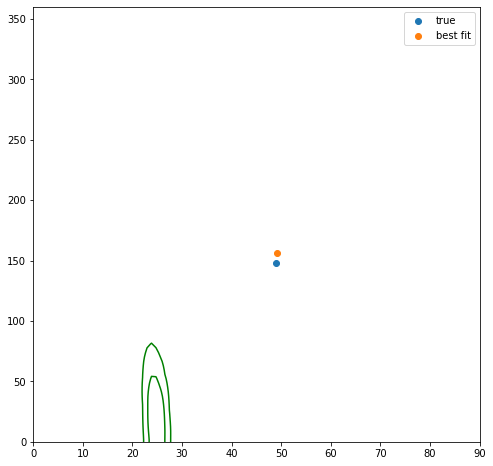

In [235]:
fig = plt.figure(figsize=(8,8))
corner.hist2d(mean[:, 1], mean[:, 2],
            levels=([0.68, 0.95]),
            scale_hist=True,
            plot_datapoints=False,
            color='green',
            labels= ["$\\theta_{23} $($^\circ$)", "$\delta_{cp} $($^\circ$)"],
            range=[[0,90], [0, 360]],
            plot_contours = True,
            plot_density = False,
            fontsize=30,
            bins = [100, 100],
            label_kwargs={"fontsize": 30},
            smooth=True
            )
plt.scatter(true_theta23[n]*180/np.pi, true_delta[n], label='true')
plt.scatter(fit_theta23[n]*180/np.pi, fit_delta[n], label='best fit')
plt.legend()
plt.show()

In [236]:
bins_theta23 = np.linspace(min(mean[:, 1]), max(mean[:, 1]), 100)
bins_delta = np.linspace(min(mean[:, 2]), max(mean[:, 2]), 100)

likeliregion, xedges, yedges = np.histogram2d(mean[:,1], mean[:,2], bins = [bins_theta23,bins_delta])
likeliregion = likeliregion.T

max_poi = np.where(likeliregion == likeliregion.max())
print("Maximum: theta23 {}, delta {} ".format(xedges[max_poi[1]],yedges[max_poi[0]]))
sorted_list = np.sort(likeliregion.reshape((len(xedges)-1)*(len(yedges)-1)))[::-1]
tot_event_num = sorted_list.sum()

count = 0
one_sigma_num, two_sigma_num = 0, 0
for i in range(len(sorted_list)):
    count += sorted_list[i]/tot_event_num
    if count >= 0.68 and one_sigma_num == 0:
        one_sigma_num = sorted_list[i]
    if count >= 0.95:
        two_sigma_num = sorted_list[i]
        break

one_sigma_region = np.where(likeliregion < one_sigma_num, 0, likeliregion)
one_sigma_region_boundary = np.where(one_sigma_region > 0, 1, one_sigma_region)
one_sigma_allowed_region = np.where(one_sigma_region_boundary != 0)

two_sigma_region = np.where(likeliregion < two_sigma_num, 0, likeliregion)
two_sigma_region_boundary = np.where(two_sigma_region > 0, 1, two_sigma_region)
two_sigma_allowed_region = np.where(two_sigma_region_boundary != 0)

xaxis, yaxis = (xedges[:-1] + xedges[1:])/2, (yedges[:-1] + yedges[1:])/2

Maximum: theta23 [24.78366453], delta [17.41729243] 


/tmp/ipykernel_2366210/2242083583.py:2: UserWarning: No contour levels were found within the data range.
  CS_1_sigma = plt.contour(xaxis, yaxis, one_sigma_region_boundary, 0, colors='green', linestyles="-", linewidths=1)
/tmp/ipykernel_2366210/2242083583.py:3: UserWarning: No contour levels were found within the data range.
  CS_2_sigma = plt.contour(xaxis, yaxis, two_sigma_region_boundary, 0, colors='red', linestyles="-", linewidths=1)


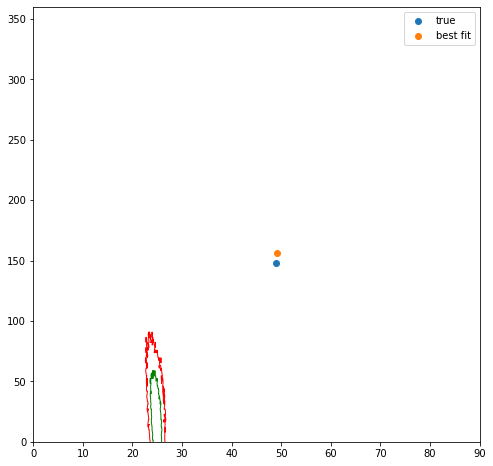

IndexError: index 99 is out of bounds for axis 0 with size 99

In [237]:
fig = plt.figure(figsize=(8,8))
CS_1_sigma = plt.contour(xaxis, yaxis, one_sigma_region_boundary, 0, colors='green', linestyles="-", linewidths=1)
CS_2_sigma = plt.contour(xaxis, yaxis, two_sigma_region_boundary, 0, colors='red', linestyles="-", linewidths=1)
plt.scatter(true_theta23[n]*180/np.pi, true_delta[n], label='true')
plt.scatter(fit_theta23[n]*180/np.pi, fit_delta[n], label='best fit')
plt.legend()
plt.xlim(0, 90)
plt.ylim(0, 360)
plt.show()

a = one_sigma_region[bisect(bins_theta23, true_theta23[n]*180/np.pi)-1][bisect(bins_delta, true_delta[n])-1] != 0.0
b = two_sigma_region[bisect(bins_theta23, true_theta23[n]*180/np.pi)-1][bisect(bins_delta, true_delta[n])-1] != 0.0
c = one_sigma_region[bisect(bins_theta23, fit_theta23[n]*180/np.pi)-1][bisect(bins_delta, fit_delta[n])-1] != 0.0
d = two_sigma_region[bisect(bins_theta23, fit_theta23[n]*180/np.pi)-1][bisect(bins_delta, fit_delta[n])-1] != 0.0
print(a, b, c, d)


**Prediction**

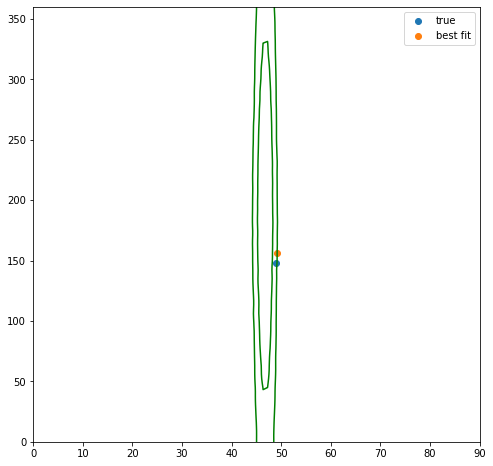

In [ ]:
fig = plt.figure(figsize=(8,8))
corner.hist2d(prediction[:, 1], prediction[:, 2],
            levels=([0.68, 0.95]),
            scale_hist=True,
            plot_datapoints=False,
            color='green',
            labels= ["$\\theta_{23} $($^\circ$)", "$\delta_{cp} $($^\circ$)"],
            range=[[0,90], [0, 360]],
            plot_contours = True,
            plot_density = False,
            fontsize=30,
            bins = [100, 100],
            label_kwargs={"fontsize": 30},
            smooth=True
            )
plt.scatter(true_theta23[n]*180/np.pi, true_delta[n], label='true')
plt.scatter(fit_theta23[n]*180/np.pi, fit_delta[n], label='best fit')
plt.legend()
plt.show()

In [ ]:
bins_theta23 = np.linspace(min(prediction[:, 1]), max(prediction[:, 1]), 100)
bins_delta = np.linspace(min(prediction[:, 2]), max(prediction[:, 2]), 100)

likeliregion, xedges, yedges = np.histogram2d(prediction[:,1], prediction[:,2], bins = [bins_theta23,bins_delta])
likeliregion = likeliregion.T

max_poi = np.where(likeliregion == likeliregion.max())
print("Maximum: theta23 {}, delta {} ".format(xedges[max_poi[1]],yedges[max_poi[0]]))
sorted_list = np.sort(likeliregion.reshape((len(xedges)-1)*(len(yedges)-1)))[::-1]
tot_event_num = sorted_list.sum()

count = 0
one_sigma_num, two_sigma_num = 0, 0
for i in range(len(sorted_list)):
    count += sorted_list[i]/tot_event_num
    if count >= 0.68 and one_sigma_num == 0:
        one_sigma_num = sorted_list[i]
    if count >= 0.95:
        two_sigma_num = sorted_list[i]
        break

one_sigma_region = np.where(likeliregion < one_sigma_num, 0, likeliregion)
one_sigma_region_boundary = np.where(one_sigma_region > 0, 1, one_sigma_region)

two_sigma_region = np.where(likeliregion < two_sigma_num, 0, likeliregion)
two_sigma_region_boundary = np.where(two_sigma_region > 0, 1, two_sigma_region)

xaxis, yaxis = (xedges[:-1] + xedges[1:])/2, (yedges[:-1] + yedges[1:])/2

Maximum: theta23 [46.95110575], delta [169.07507047] 


/tmp/ipykernel_2366210/2242083583.py:2: UserWarning: No contour levels were found within the data range.
  CS_1_sigma = plt.contour(xaxis, yaxis, one_sigma_region_boundary, 0, colors='green', linestyles="-", linewidths=1)
/tmp/ipykernel_2366210/2242083583.py:3: UserWarning: No contour levels were found within the data range.
  CS_2_sigma = plt.contour(xaxis, yaxis, two_sigma_region_boundary, 0, colors='red', linestyles="-", linewidths=1)


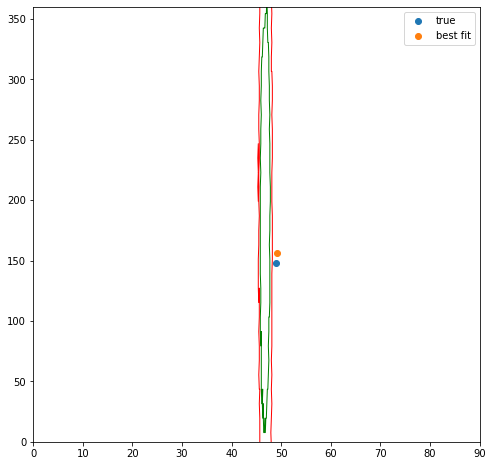

False False False False


In [ ]:
fig = plt.figure(figsize=(8,8))
CS_1_sigma = plt.contour(xaxis, yaxis, one_sigma_region_boundary, 0, colors='green', linestyles="-", linewidths=1)
CS_2_sigma = plt.contour(xaxis, yaxis, two_sigma_region_boundary, 0, colors='red', linestyles="-", linewidths=1)
plt.scatter(true_theta23[n]*180/np.pi, true_delta[n], label='true')
plt.scatter(fit_theta23[n]*180/np.pi, fit_delta[n], label='best fit')
plt.legend()
plt.xlim(0, 90)
plt.ylim(0, 360)
plt.show()

a = one_sigma_region[bisect(bins_theta23, true_theta23[n]*180/np.pi)-1][bisect(bins_delta, true_delta[n])-1] != 0.0
b = two_sigma_region[bisect(bins_theta23, true_theta23[n]*180/np.pi)-1][bisect(bins_delta, true_delta[n])-1] != 0.0
c = one_sigma_region[bisect(bins_theta23, fit_theta23[n]*180/np.pi)-1][bisect(bins_delta, fit_delta[n])-1] != 0.0
d = two_sigma_region[bisect(bins_theta23, fit_theta23[n]*180/np.pi)-1][bisect(bins_delta, fit_delta[n])-1] != 0.0
print(a, b, c, d)
